## II.4. Simple decomposition methods

Time series decomposition is a fundamental technique used to deconstruct a time series into several constituent components. By separating the series into its parts, we can better understand its underlying structure, identify patterns, and produce a seasonally adjusted series for further analysis or modeling.

### II.4.A. What is decomposition?

The core idea is to model the observed time series $y_t$ as a function of three key components:

1.  **Trend-Cycle ($\tau_t$)**: The long-term direction or underlying trend of the series. This component captures the slow-moving, non-periodic changes.
2.  **Seasonal ($\sigma_t$)**: The periodic fluctuations that occur at fixed intervals, such as daily, monthly, or quarterly patterns.
3.  **Irregular or Residual ($\epsilon_t$)**: The leftover random noise or error component that is not explained by the trend and seasonal components.


The general relationship is expressed as:
$$
y_t = f(\tau_t, \sigma_t, \epsilon_t)
$$

This approach is based on the hypotheses that the series contains: 

- an identifiable long-term **trend**,
- exhibits some form of regular **periodicity** (seasonality),
- and that these systematic components can be separated from irregular noise (uncertainty).

### II.4.B. Types of decomposition models

The way the components are combined defines the type of decomposition model.

#### Additive Model
The components are summed together. This model is appropriate when the magnitude of the seasonal fluctuations **does not** vary with the level of the time series.

$$
y_t = \tau_t + \sigma_t + \epsilon_t
$$

#### Multiplicative Model
The components are multiplied. This is very common in economic series, where the seasonal variation tends to increase as the level of the series rises.

$$
y_t = \tau_t \times \sigma_t \times \epsilon_t
$$

A key property of the multiplicative model is that it can be transformed into an additive one by taking the natural logarithm:
$$
\log(y_t) = \log(\tau_t) + \log(\sigma_t) + \log(\epsilon_t)
$$

#### Pseudo-additive (hybrid) model

This model combines multiplicative and additive elements, for instance, when a trend is multiplicative but the seasonality is additive around it.
$$
y_t = \tau_t \times (\sigma_t + \epsilon_t)
$$

#### Example: Additive decomposition

In [1]:
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.datasets import load_airline

In [2]:
from utils import plot_decomposition, plot_residuals, plot_series

##### Manual decomposition

In [3]:
y = load_airline()

# Trend:
trend_forecaster = PolynomialTrendForecaster(degree=1)
detrender = Detrender(forecaster=trend_forecaster)
trend = trend_forecaster.fit(y).predict(fh=y.index)

y_detrended = detrender.fit_transform(y)

# Seasonality:
deseasonalizer = Deseasonalizer(sp=12, model="additive")
seasonality = y_detrended - deseasonalizer.fit_transform(y_detrended)

# Residual:
residual = y - (trend + seasonality)

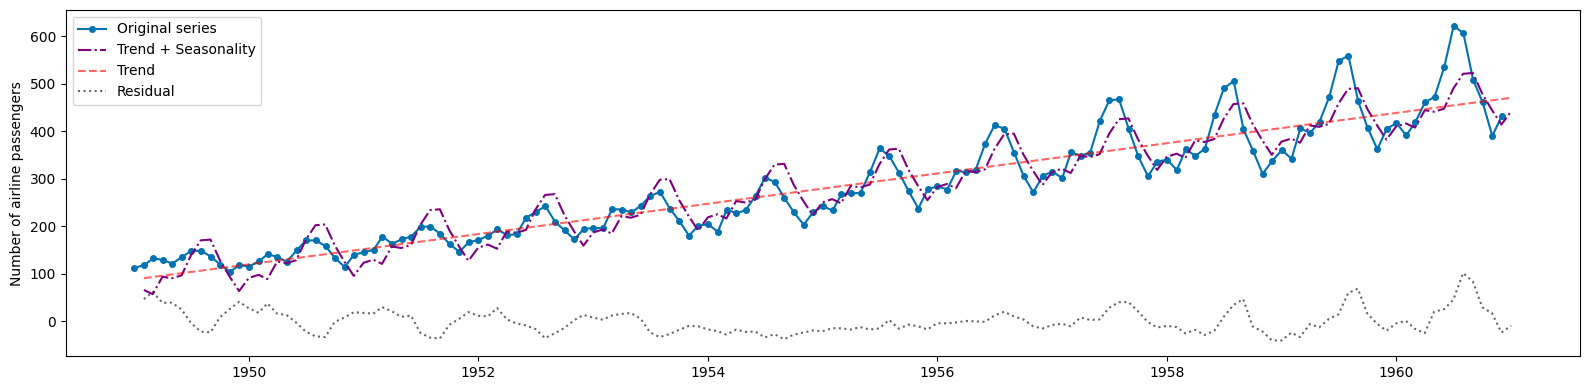

In [4]:
fix, ax = plot_decomposition(y, trend=trend, seasonality=seasonality, residual=residual)

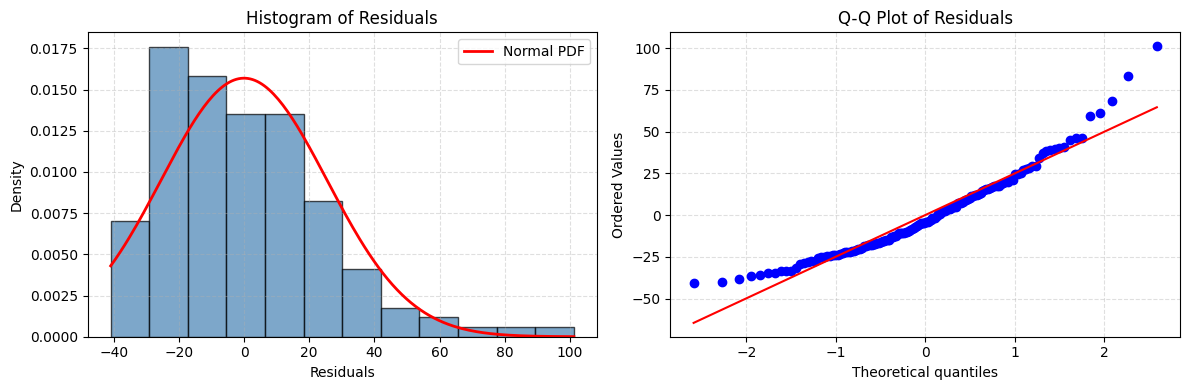

In [5]:
plot_residuals(residual)

##### Using pipelines

In [6]:
from sktime.transformations.compose import TransformerPipeline

In [7]:
y = load_airline()

pipe = TransformerPipeline(steps=[
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("deseasonalize", Deseasonalizer(model="additive", sp=12)),
])

residual = pipe.fit_transform(y)

# Get trend
detrender = pipe.steps_[0][1]
y_detrended = detrender.transform(y)
trend = y - y_detrended

# seasonality:
deseasonalizer = pipe.steps_[1][1]
seasonality = y_detrended - deseasonalizer.transform(y_detrended)

# Residual:
residual = y - (trend + seasonality)

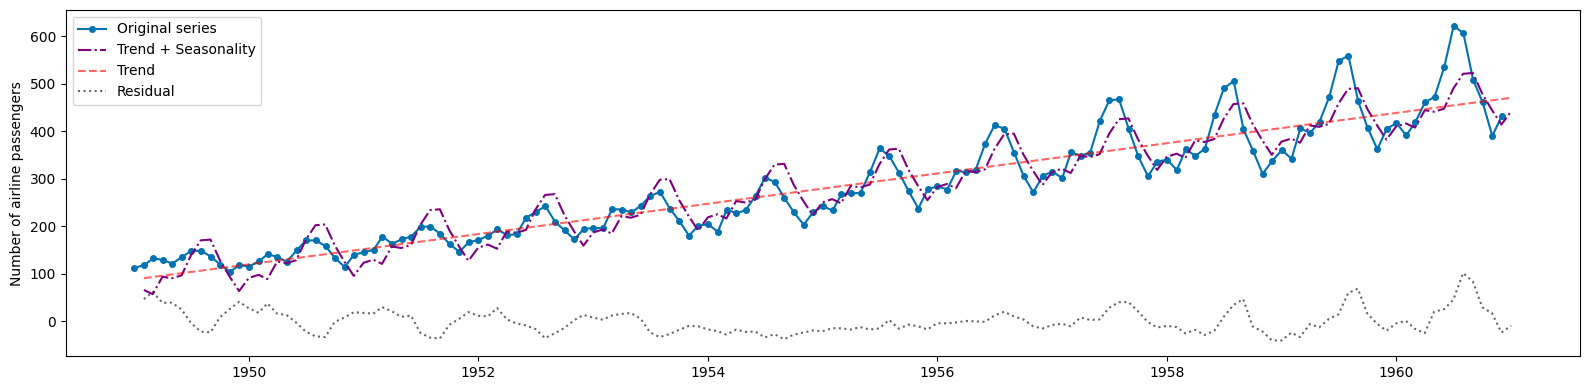

In [8]:
fix, ax = plot_decomposition(y, trend=trend, seasonality=seasonality, residual=residual)

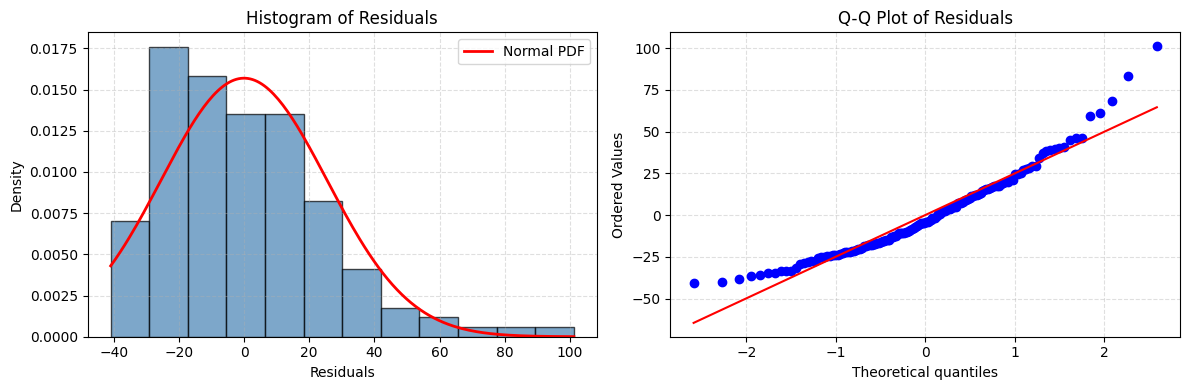

In [9]:
plot_residuals(residual)

#### Example: Multiplicative decomposition

In [10]:
y = load_airline()

# trend 
trend_forecaster = PolynomialTrendForecaster(degree=1)
detrender = Detrender(forecaster=trend_forecaster)
trend = trend_forecaster.fit(y).predict(fh=y.index)
y_detrended = y / trend

# Seasonality
deseasonalizer = Deseasonalizer(sp=12, model="multiplicative")
seasonality = y_detrended / deseasonalizer.fit_transform(y_detrended)

# Residual
residual = y / (trend * seasonality)

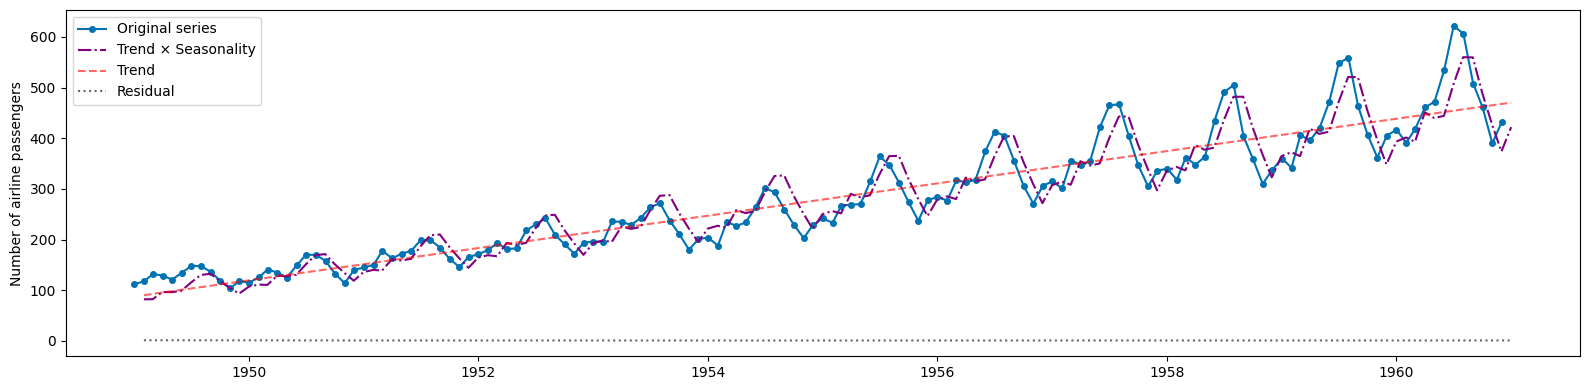

In [11]:
fix, ax = plot_decomposition(y, trend=trend, seasonality=seasonality, residual=residual, model="multiplicative")

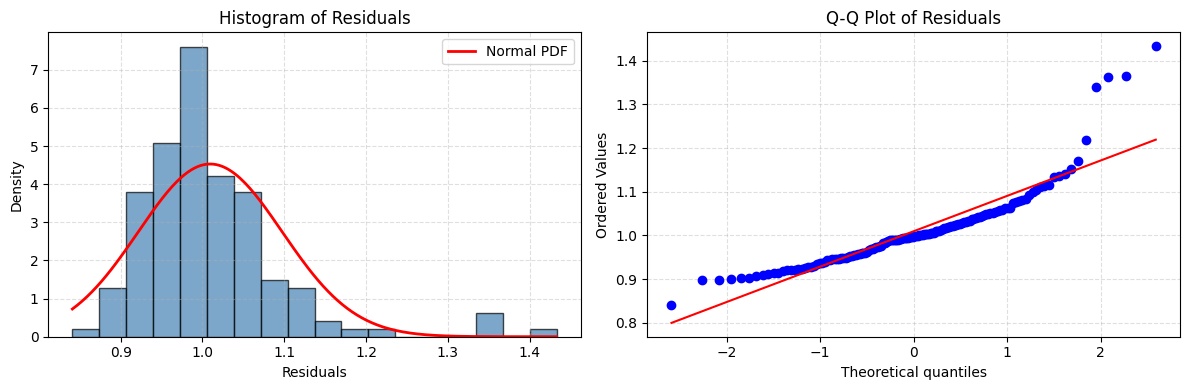

In [12]:
plot_residuals(residual)

#### Other advanced decomposition methods: X-11 and SEATS

Classical decomposition is a simple and useful exploratory tool, but it has drawbacks:

- The trend estimate is unavailable for the first and last few data points.
- It assumes the seasonal component repeats exactly from year to year.
- It is sensitive to outliers.

More advanced methods have been developed to overcome these issues, with [X-13-ARIMA-SEATS](https://www.census.gov/data/software/x13as.html) (from the US Census Bureau) and [TRAMO-SEATS](https://es.wikipedia.org/wiki/TRAMO-SEATS) (from the **Bank of Spain**) being the industry standard for official statistics.

**Key advantages** of these methods include:

- Better End-Point Handling: They "recover" the lost data at the ends of the trend component.
- Evolving Seasonality: The seasonal component is allowed to change gradually over time.
- Robustness: They can handle calendar effects (trading days, moving holidays) and outliers as part of the decomposition process.

These methods are available through `statsmodels` and can be integrated into an `sktime` workflow for more robust seasonal adjustment and analysis.

#### Automated with STL: Seasonal and trend decomposition using Loess


STL is a versatile and robust method for decomposing a time series into its trend, seasonal, and residual components. It was developed by R. B. Cleveland et al. and represents a significant advancement over classical decomposition methods. The name "STL" is an acronym for "Seasonal and Trend decomposition using Loess," where Loess is the key to its flexibility.

STL can handle any type of seasonality (not just monthly or quarterly) and the seasonal component is allowed to change over time. Its most significant advantage comes from the use of **Loess** (Locally Estimated Scatterplot Smoothing), a non-parametric regression method.

Instead of fitting a single polynomial to the entire dataset to find the trend, Loess fits numerous simple linear models on small, localized subsets of the data. This allows it to capture complex and changing patterns without making rigid assumptions about the data's underlying structure.

Key advantages of STL include:
* **Robustness to outliers**: STL includes an outer loop that iteratively calculates "robustness weights" to reduce the influence of outliers on the final decomposition.
* **Flexibility**: It can decompose series with complex or changing seasonal patterns.
* **Control**: The user can control the smoothness of the trend and the rate of change in the seasonal component.

##### Bonus: An intuitive overview of the STL algorithm

STL uses a two-loop procedure:

1.  **The Inner Loop**: Iteratively separates the trend and seasonal components.
    * **(a) Detrending**: An initial trend estimate is subtracted from the series.
    * **(b) Cycle-Subseries Smoothing**: The detrended series is broken down into seasonal sub-series (e.g., all the January values, all the February values, etc.). Loess is then applied to smooth each of these sub-series.
    * **(c) Filtering**: The collection of smoothed sub-series is filtered to produce the final seasonal component for this iteration.
    * **(d) Detrending again**: The seasonal component is subtracted from the original series, and Loess is applied to smooth the result to find the trend component for this iteration.

2.  **The Outer Loop**: This is what provides robustness.
    * After an inner loop completes, the residuals ($y_t - \tau_t - \sigma_t$) are calculated.
    * Large residuals (potential outliers) are identified, and "robustness weights" are calculated for each data point. Points with large residuals are given small (or zero) weights.
    * The entire inner loop is then repeated, but this time the Loess smoothing steps use these weights, effectively downplaying the influence of outliers. This outer loop is typically repeated a few times.


##### Example: Decomposing atmospheric CO2 from continuous air samples

In [13]:
from matplotlib import pyplot as plt
from sktime.transformations.series.detrend import STLTransformer

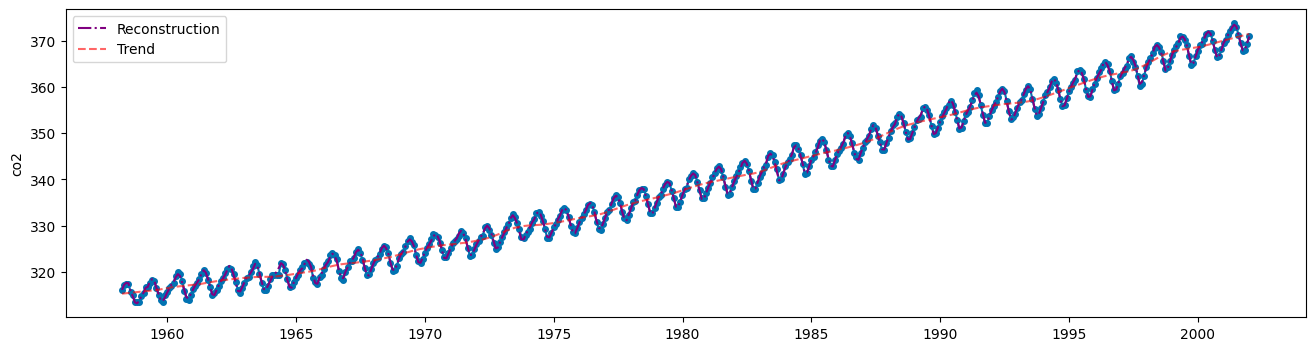

In [21]:
from statsmodels.datasets import co2

y = co2.load().data.resample('ME').mean().ffill()

transformer = STLTransformer(sp=12, return_components=True)  
y_t = transformer.fit_transform(y)  

fig, ax = plot_series(y)
ax.plot(y_t.trend + y_t.seasonal, color="purple", linestyle="-.", label="Reconstruction")
ax.plot(y_t.trend, color="red", linestyle="--", alpha=0.6, label="Trend")
plt.legend()
plt.show()

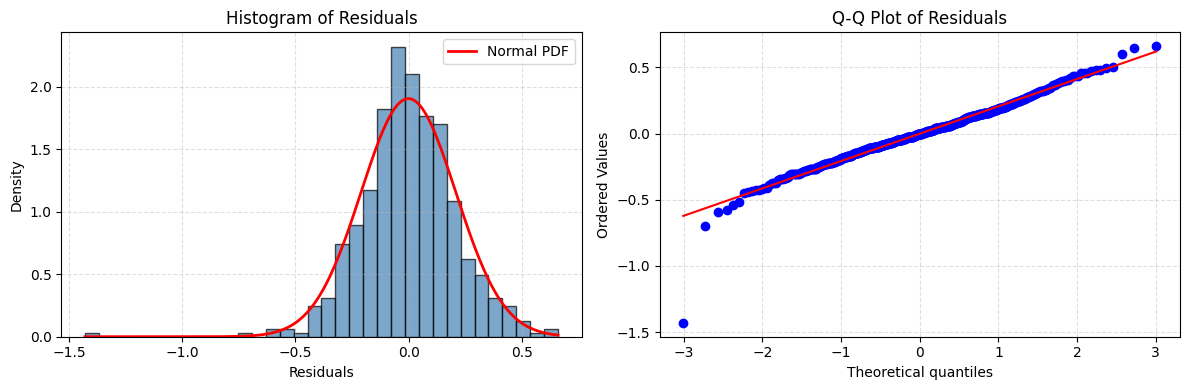

In [15]:
plot_residuals(y_t.resid)

##### Example: Decomposing Australia's electricty demand 

In [16]:
from utils import ExampleDataLoader, plot_series_slice
from sktime.transformations.series.detrend.mstl import MSTL

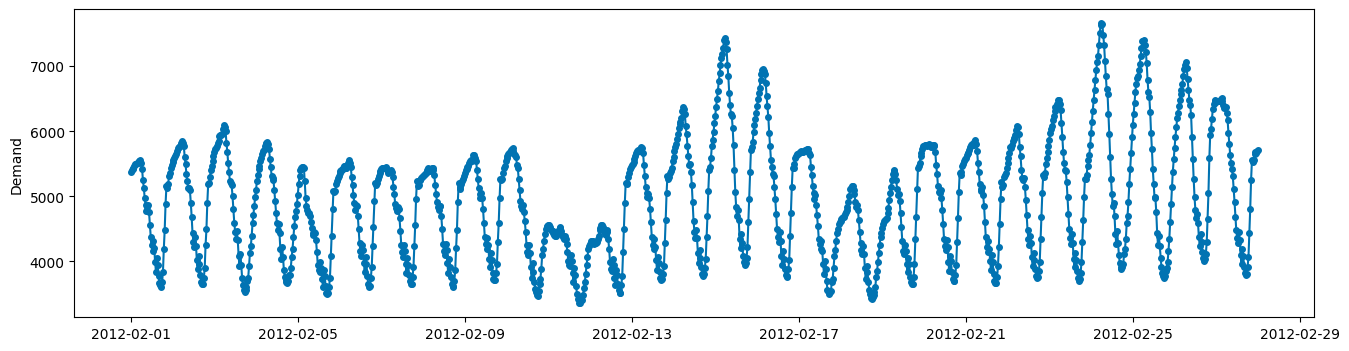

In [17]:
electricity_df = ExampleDataLoader("electricity").load().set_index("Time")
electricity_df.index

y = plot_series_slice(
    electricity_df["Demand"],
    start="2012-02-01 00:00:00+00:00",
    stop="2012-02-28 00:00:00+00:00",
    freq="30 min",
    return_data=True
)

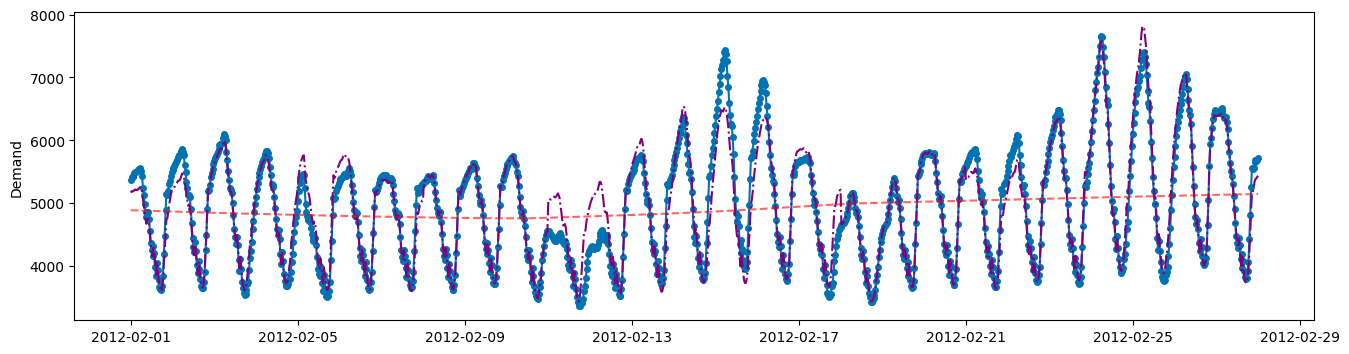

In [18]:
transformer = STLTransformer(sp=24*20, return_components=True)  
y_t = transformer.fit_transform(y)  

fig, ax = plot_series(y)
ax.plot(y_t.trend + y_t.seasonal, color="purple", linestyle="-.", label="Reconstruction")
ax.plot(y_t.trend, color="red", linestyle="--", alpha=0.6, label="Trend")

In [19]:
transformer = MSTL(periods=[24, 24*7], return_components=True)
y_t = transformer.fit_transform(y)  
y_t.head(5)

,trend,resid,seasonal_24,seasonal_168
2012-02-01 00:00:00+00:00,5122.836824,232.540988,-289.045005,306.466394
2012-02-01 00:30:00+00:00,5120.444990,266.119958,-276.782853,298.954301
2012-02-01 01:00:00+00:00,5118.055893,233.655086,-188.901324,256.967580
2012-02-01 01:30:00+00:00,5115.669531,271.066930,-196.925170,246.381832
2012-02-01 02:00:00+00:00,5113.285894,327.549816,-228.341312,260.373215
